In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.optim as optims
from torch import nn
import torch.utils.data as Data
import os
import math
import time
from sklearn.linear_model import Lasso,LassoCV, LassoLarsIC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv,yv
torch.set_printoptions(precision=8)
torch.manual_seed(1)
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
torch.set_default_dtype(torch.float64)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['font.sans-serif'] = 'Microsoft YaHei' #'Arial'
plt.rcParams['axes.unicode_minus'] = False
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
pi = math.pi
l_bd = 0.0
r_bd = 1.0

cuda:1


lam1= 1.0 lam2= 0.0001
计算特解系数矩阵耗时= 17.758655786514282
初始误差,err_norm= tensor(2.41376376e+08)


/home/wzw/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+07, tolerance: 1.214e+07
  model = cd_fast.enet_coordinate_descent(


使用指定的lam= 0.1
lasso求解后误差,err_norm= tensor(5452.85781936)


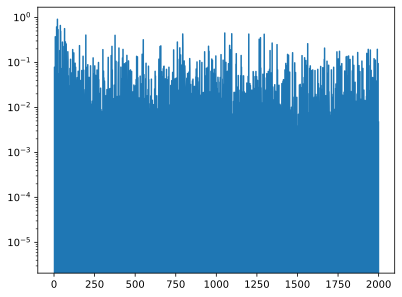

The number of RBFs before discarding：2000
The number of RBFs after discarding：1256
基函数个数= 1256 当前损失为= tensor(20589.39413415)


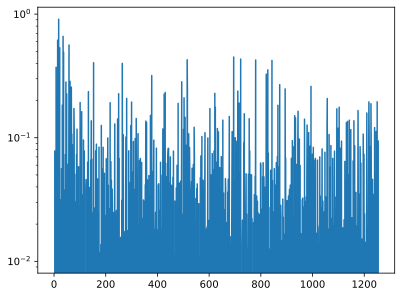

k=50,t_all=1.250,t_Niter=1.250,Niter:1,loss:151101683523.50518799,lr:0.01000000
k=50,t_all=2.154,t_Niter=0.904,Niter:2,loss:1745756300.91440511,lr:0.01000000
k=50,t_all=3.117,t_Niter=0.963,Niter:3,loss:133816753.42410064,lr:0.01000000
k=50,t_all=4.248,t_Niter=1.131,Niter:4,loss:45878777.57187548,lr:0.01000000
k=50,t_all=5.150,t_Niter=0.902,Niter:5,loss:37538346.36388116,lr:0.01000000
k=50,t_all=6.064,t_Niter=0.915,Niter:6,loss:34958878.09268165,lr:0.01000000
k=50,t_all=6.963,t_Niter=0.899,Niter:7,loss:33150965.26823700,lr:0.01000000
k=50,t_all=8.040,t_Niter=1.077,Niter:8,loss:32611097.95575196,lr:0.01000000
k=50,t_all=8.945,t_Niter=0.906,Niter:9,loss:32176331.85528746,lr:0.01000000
k=50,t_all=9.880,t_Niter=0.934,Niter:10,loss:30758113.31182172,lr:0.01000000
k=50,t_all=10.793,t_Niter=0.913,Niter:11,loss:30789815.31311397,lr:0.01000000
k=50,t_all=11.899,t_Niter=1.107,Niter:12,loss:30520889.05563278,lr:0.01000000
k=50,t_all=12.829,t_Niter=0.930,Niter:13,loss:30882293.33643219,lr:0.0100000

tensor(0.03369048)

In [24]:
def xyToPolar(X,c):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    z = X[:,2].reshape(-1,1)
    return torch.sqrt(x**2+y**2+z**2)

def xycToPolar(X,c):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    z = X[:,2].reshape(-1,1)
    return torch.sqrt((x.unsqueeze(1)-c[:,0].reshape(-1,1))**2+\
                      (y.unsqueeze(1)-c[:,1].reshape(-1,1))**2+\
                      (z.unsqueeze(1)-c[:,2].reshape(-1,1))**2).squeeze(-1)

def get_u(X,c,h):
    r = xycToPolar(X,c)
    r[r==0] = 1e-15
    Phi = torch.sin(k*r)/r
    u = torch.matmul(Phi,h).reshape(-1,1)
    return u

def get_u_dx(X,c,h):
    x = X[:,0].reshape(-1,1)-c[:,0].reshape(1,-1)
    r = xycToPolar(X,c) #m*n
    r[r==0] = 1e-15
    Phi = (k*x*r*torch.cos(k*r)-torch.sin(k*r)*x)/r**3
    u_dx = torch.matmul(Phi,h).reshape(-1,1)
    return u_dx

def get_u_dy(X,c,h):
    y = X[:,1].reshape(-1,1)-c[:,1].reshape(1,-1)
    r = xycToPolar(X,c) #m*n
    r[r==0] = 1e-15
    Phi = (k*y*r*torch.cos(k*r)-torch.sin(k*r)*y)/r**3
    u_dy = torch.matmul(Phi,h).reshape(-1,1)
    return u_dy

def get_u_dz(X,c,h):
    z = X[:,2].reshape(-1,1)-c[:,2].reshape(1,-1)
    r = xycToPolar(X,c) #m*n
    r[r==0] = 1e-15
    Phi = (k*z*r*torch.cos(k*r)-torch.sin(k*r)*z)/r**3
    u_dz = torch.matmul(Phi,h).reshape(-1,1)
    return u_dz


def get_u_dc(X,c,h):
    x = -(X[:,0].reshape(-1,1)-c[:,0].reshape(1,-1))
    y = -(X[:,1].reshape(-1,1)-c[:,1].reshape(1,-1))
    z = -(X[:,2].reshape(-1,1)-c[:,2].reshape(1,-1))
    r = xycToPolar(X,c) #m*n
    r[r==0] = 1e-15
    Phi_1 = h*(k*x*r*torch.cos(k*r)-torch.sin(k*r)*x)/r**3
    Phi_2 = h*(k*y*r*torch.cos(k*r)-torch.sin(k*r)*y)/r**3
    Phi_3 = h*(k*z*r*torch.cos(k*r)-torch.sin(k*r)*z)/r**3
    return torch.cat((Phi_1.unsqueeze(-1),Phi_2.unsqueeze(-1),Phi_3.unsqueeze(-1)),-1)
    
def get_u_dh(X,c):
    r = xycToPolar(X,c)
    r[r==0] = 1e-15
    Phi = torch.sin(k*r)/r
    return Phi


def u_exact(X):
    u = (torch.cos(k*X[:,0])+torch.cos(k*X[:,1])+torch.cos(k*X[:,2])+torch.sin(pi*(X[:,0]+X[:,1]+X[:,2]))).reshape(-1,1)
    return u

def u_dx_exact(X):
    u_dx = (-k*torch.sin(k*X[:,0])+pi*torch.cos(pi*(X[:,0]+X[:,1]+X[:,2]))).reshape(-1,1)
    return u_dx

def u_dy_exact(X):
    u_dy = (-k*torch.sin(k*X[:,1])+pi*torch.cos(pi*(X[:,0]+X[:,1]+X[:,2]))).reshape(-1,1)
    return u_dy

def u_dz_exact(X):
    u_dz = (-k*torch.sin(k*X[:,2])+pi*torch.cos(pi*(X[:,0]+X[:,1]+X[:,2]))).reshape(-1,1)
    return u_dz

def generate_term(x):
    f = ((k**2-3*math.pi**2)*torch.sin(math.pi*(x[:,0]+x[:,1]+x[:,2]))).reshape(-1,1)
    return f

def SampleBoundPoints(n_bd=100):
    torch.manual_seed(1)
    x = torch.linspace(l_bd,r_bd,n_bd)
    mx,my = torch.meshgrid((x,x))
    mx,my = mx.reshape(-1,1),my.reshape(-1,1)
    z = torch.zeros_like(mx)
    X_1 = torch.cat((mx, my,z), dim=1)  # (x,y,0)
    X_2 = torch.cat((mx, my,z+1), dim=1)  # (x,y,1)
    X_3 = torch.cat((mx, z+1,my), dim=1)  # (x,1,z)
    X_4 = torch.cat((mx, z,my), dim=1)  # (x,0,z)
    X_5 = torch.cat((z, mx,my), dim=1)  # (0,y,z)
    X_6 = torch.cat((z+1 , mx,my), dim=1)  # (1,y,z)
    x_bd = torch.cat((X_1,X_2,X_3,X_4,X_5,X_6),0) 
    return x_bd

def drop_bf1(net,tol2=0.00001):
    net = net.cpu()
    print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
    c, h ,w= net.center.detach(), net.hight.detach(), net.width.detach()
    index = torch.where(abs(h) > tol2)[0]
    c1 = torch.index_select(c, 0, index)
    h1 = torch.index_select(h, 0, index)
    w1 = torch.index_select(w, 0, index)
    net.center = nn.Parameter(c1)
    net.hight = nn.Parameter(h1)
    net.width = nn.Parameter(w1)
    print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    return net


def drop_bf(net,tol=10):
    if tol>1:
        if tol>=net.hight.data.shape[0]:
            return net
        net = net.cpu()
        print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
        c, h = net.center.detach(), net.hight.detach()
        top_values, index = torch.topk(abs(h), k=tol, largest=True)
        c1 = torch.index_select(c, 0, index)
        h1 = torch.index_select(h, 0, index)
        net.center = nn.Parameter(c1)
        net.hight = nn.Parameter(h1)
        print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    else:
        net = net.cpu()
        print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
        c, h = net.center.detach(), net.hight.detach()
        index = torch.where(abs(h) > tol)[0]
        c1 = torch.index_select(c, 0, index)
        h1 = torch.index_select(h, 0, index)
        net.center = nn.Parameter(c1)
        net.hight = nn.Parameter(h1)
        print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    return net

class GaussNet(nn.Module):
    def __init__(self, N):
        super(GaussNet, self).__init__()
        torch.manual_seed(1)
        self.hight = nn.Parameter(torch.rand(N)) 
        self.center = nn.Parameter((r_bd-l_bd)*torch.rand(N,3)+l_bd)
        self.width = nn.Parameter((torch.rand(N,1))*math.pi)
    
    def forward(self,X):  
        J = self.cal_J(X)
        output = torch.matmul(self.hight,J)  # n*[n*m] ==> m
        return output.reshape(-1,1) # m
    
    def cal_J(self,X):
        x = (X[:, 0]).view(-1, 1)  # m*1
        y = (X[:, 1]).view(-1, 1)  # m*1
        z = (X[:, 2]).view(-1, 1)  # m*1
        x1 = (x - (self.center[:, 0]).view(-1, 1, 1))  # n*m*1
        y1 = (y - (self.center[:, 1]).view(-1, 1, 1))
        z1 = (z - (self.center[:, 2]).view(-1, 1, 1))
        d1 = (self.width ** 2).view(-1, 1, 1)  # n*1*1
        r = -torch.matmul(x1 ** 2, d1)-torch.matmul(y1 ** 2, d1)-torch.matmul(z1 ** 2, d1)  # n*m*1
        J = torch.exp(r)
        return J.squeeze(-1)
        
    def cal_dx(self,X):
        u_dx_J = self.cal_dx_J(X)
        output = torch.matmul(self.hight, u_dx_J)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m

    def cal_dx_J(self,X):
        x = (X[:, 0]).view(-1, 1)  # m*1
        y = (X[:, 1]).view(-1, 1)  # m*1
        z = (X[:, 2]).view(-1, 1)  # m*1
        x1 = (x - (self.center[:, 0]).view(-1, 1, 1))  # n*m*1
        y1 = (y - (self.center[:, 1]).view(-1, 1, 1))
        z1 = (z - (self.center[:, 2]).view(-1, 1, 1))
        d1 = (self.width ** 2).view(-1, 1, 1)  # n*1*1
        r = -torch.matmul(x1 ** 2, d1)-torch.matmul(y1 ** 2, d1)-torch.matmul(z1 ** 2, d1)  # n*m*1
        u_dx_J = -2*torch.matmul(x1,d1)*torch.exp(r)
        return u_dx_J.squeeze(-1)
           
    def cal_dy(self,X):
        u_dy_J = self.cal_dy_J(X)
        output = torch.matmul(self.hight, u_dy_J)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m
    
    def cal_dy_J(self,X):
        x = (X[:, 0]).view(-1, 1)  # m*1
        y = (X[:, 1]).view(-1, 1)  # m*1
        z = (X[:, 2]).view(-1, 1)  # m*1
        x1 = (x - (self.center[:, 0]).view(-1, 1, 1))  # n*m*1
        y1 = (y - (self.center[:, 1]).view(-1, 1, 1))
        z1 = (z - (self.center[:, 2]).view(-1, 1, 1))
        d1 = (self.width ** 2).view(-1, 1, 1)  # n*1*1
        r = -torch.matmul(x1 ** 2, d1)-torch.matmul(y1 ** 2, d1)-torch.matmul(z1 ** 2, d1)  # n*m*1
        u_dy_J = -2 * torch.matmul(y1, d1) * torch.exp(r)
        return u_dy_J.squeeze(-1)

    def cal_dz(self,X):
        u_dz_J = self.cal_dz_J(X)
        output = torch.matmul(self.hight, u_dz_J)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m
    
    def cal_dz_J(self,X):
        x = (X[:, 0]).view(-1, 1)  # m*1
        y = (X[:, 1]).view(-1, 1)  # m*1
        z = (X[:, 2]).view(-1, 1)  # m*1
        x1 = (x - (self.center[:, 0]).view(-1, 1, 1))  # n*m*1
        y1 = (y - (self.center[:, 1]).view(-1, 1, 1))
        z1 = (z - (self.center[:, 2]).view(-1, 1, 1))
        d1 = (self.width ** 2).view(-1, 1, 1)  # n*1*1
        r = -torch.matmul(x1 ** 2, d1)-torch.matmul(y1 ** 2, d1)-torch.matmul(z1 ** 2, d1)  # n*m*1
        u_dz_J = -2 * torch.matmul(z1, d1) * torch.exp(r)
        return u_dz_J.squeeze(-1)
    
    def cal_dxx(self,X):
        u_dxx_J = self.cal_dxx_J(X)
        output = torch.matmul(self.hight, u_dxx_J)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m

    def cal_dxx_J(self,X):
        x = (X[:, 0]).view(-1, 1)  # m*1
        y = (X[:, 1]).view(-1, 1)  # m*1
        z = (X[:, 2]).view(-1, 1)  # m*1
        x1 = (x - (self.center[:, 0]).view(-1, 1, 1))  # n*m*1
        y1 = (y - (self.center[:, 1]).view(-1, 1, 1))
        z1 = (z - (self.center[:, 2]).view(-1, 1, 1))
        d1 = (self.width ** 2).view(-1, 1, 1)  # n*1*1
        r = -torch.matmul(x1 ** 2, d1)-torch.matmul(y1 ** 2, d1)-torch.matmul(z1 ** 2, d1)  # n*m*1
        u_dxx_J = 4*torch.matmul(x1**2,d1**2)*torch.exp(r)-2*d1*torch.exp(r)
        return u_dxx_J.squeeze(-1)
    
    def cal_dyy(self,X): 
        u_dyy_J = self.cal_dyy_J(X)
        output = torch.matmul(self.hight, u_dyy_J)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m
    
    def cal_dyy_J(self,X):
        x = (X[:, 0]).view(-1, 1)  # m*1
        y = (X[:, 1]).view(-1, 1)  # m*1
        z = (X[:, 2]).view(-1, 1)  # m*1
        x1 = (x - (self.center[:, 0]).view(-1, 1, 1))  # n*m*1
        y1 = (y - (self.center[:, 1]).view(-1, 1, 1))
        z1 = (z - (self.center[:, 2]).view(-1, 1, 1))
        d1 = (self.width ** 2).view(-1, 1, 1)  # n*1*1
        r = -torch.matmul(x1 ** 2, d1)-torch.matmul(y1 ** 2, d1)-torch.matmul(z1 ** 2, d1)  # n*m*1
        u_dyy_J = 4 * torch.matmul(y1**2, d1**2) * torch.exp(r)-2*d1*torch.exp(r)
        return u_dyy_J.squeeze(-1)

    def cal_dzz(self,X): 
        u_dzz_J = self.cal_dzz_J(X)
        output = torch.matmul(self.hight, u_dzz_J)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m
    
    def cal_dzz_J(self,X):
        x = (X[:, 0]).view(-1, 1)  # m*1
        y = (X[:, 1]).view(-1, 1)  # m*1
        z = (X[:, 2]).view(-1, 1)  # m*1
        x1 = (x - (self.center[:, 0]).view(-1, 1, 1))  # n*m*1
        y1 = (y - (self.center[:, 1]).view(-1, 1, 1))
        z1 = (z - (self.center[:, 2]).view(-1, 1, 1))
        d1 = (self.width ** 2).view(-1, 1, 1)  # n*1*1
        r = -torch.matmul(x1 ** 2, d1)-torch.matmul(y1 ** 2, d1)-torch.matmul(z1 ** 2, d1)  # n*m*1
        u_dzz_J = 4 * torch.matmul(z1**2, d1**2) * torch.exp(r)-2*d1*torch.exp(r)
        return u_dzz_J.squeeze(-1)

n_in = 40000
def solve_part_sol(net1,lam=0.1,use_lstsq=False):
    torch.manual_seed(1)
    x_in = torch.rand(n_in,3)
    if net1.center.is_cuda:
        x_in = x_in.to(device)
    f = generate_term(x_in)
    t1 = time.time()
    # x_in = x_in.to(device)
    # net1 = net1.to(device)
    x_bd = SampleBoundPoints(2*k)
    with torch.no_grad():
        A = net1.cal_dxx_J(x_in)+net1.cal_dyy_J(x_in)+net1.cal_dzz_J(x_in)+k**2*net1.cal_J(x_in)
        A = A.T
        A_bd = net1.cal_dxx_J(x_bd)+net1.cal_dyy_J(x_bd)+net1.cal_dzz_J(x_bd)+k**2*net1.cal_J(x_bd)
        A_bd = A_bd.T
    lam1 = 1.0#100/torch.max(torch.abs(A))
    lam2 = 0.0001#10/torch.max(torch.abs(A_bd))
    print('lam1=',lam1,'lam2=',lam2)
    A = torch.cat((lam1*A,lam2*A_bd),0).cpu()
    f = torch.cat((lam1*f,lam2*torch.zeros(A_bd.shape[0],1)),0).cpu()
    t2 = time.time()
    print('计算特解系数矩阵耗时=',t2-t1)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net1.hight.data).reshape(-1,1)-f))
    if use_lstsq:
        h_new = torch.linalg.lstsq(A,f,driver='gelsd')[0]
    else:
        clf = Lasso(lam,fit_intercept=False)
        clf.fit(A,f) 
        print('使用指定的lam=',lam)
        h_new = torch.tensor(clf.coef_)
    net1 = net1.cpu()
    net1.hight = nn.Parameter(h_new.flatten())
    print("lasso求解后误差,err_norm=",torch.norm(torch.matmul(A,net1.hight.data).reshape(-1,1)-f))
    return net1

def cal_mse_loss():
    torch.manual_seed(1)
    x_in = torch.rand(n_in,3)
    if net1.center.is_cuda:
        x_in = x_in.to(device)
    
    f = generate_term(x_in)
    t1 = time.time()
    with torch.no_grad():
        A = net1.cal_dxx_J(x_in)+net1.cal_dyy_J(x_in)+net1.cal_dzz_J(x_in)+k**2*net1.cal_J(x_in)
        A = A.T
    loss = torch.norm(torch.matmul(A,net1.hight.data).reshape(-1,1)-f)
    print("基函数个数=",net1.hight.data.shape[0],"当前损失为=",loss)
    return loss

k=50
net1 = GaussNet(2000)
net1 = solve_part_sol(net1)
plt.plot(net1.hight.data)
plt.semilogy()
plt.show()
net1 = drop_bf1(net1,0.01)
cal_mse_loss()
plt.plot(net1.hight.data)
plt.semilogy()
plt.show()
# net1.load_state_dict(torch.load('model/2d_exam7_net1_%d.pth'%int(k)))
# print(net1.hight.data.shape)
torch.save(net1.state_dict(), 'model/2d_exam7_net1_init_%d.pth'%int(k))


def train1(net1):
    lr = 0.01
    t_all = 0.0
    torch.manual_seed(1)
    x_in = torch.rand(n_in,3)
    # x_in = x_in.to(device)
    f = generate_term(x_in)
    # f = f.to(device)
    net1 = net1.to(device)
    # net.center.requires_grad=True
    # net.hight.requires_grad=True
    # net.width.requires_grad=True
    optimizer = optims.Adam([{"params":net1.center,"lr":lr},{"params":net1.width,"lr":lr},{"params":net1.hight,"lr":lr}])
    dataset = Data.TensorDataset(x_in,f)
    data_iter = Data.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)
    for Niter in range(1, 800):
        l_sum = 0.0
        t1 = time.time()
        for x1,f1 in data_iter:
            optimizer.zero_grad()
            x1 = x1.to(device)
            f1 = f1.to(device)
            loss = ((net1.cal_dxx(x1)+net1.cal_dyy(x1)+net1.cal_dzz(x1)+k**2*net1(x1)-f1)**2).sum() 
            loss.backward()
            optimizer.step()
            l_sum += loss.cpu().item()
        t2 = time.time()
        t_all += t2-t1
        if (Niter%200==0)&(optimizer.param_groups[0]['lr']>=1e-10):
            for i in range(len(optimizer.param_groups)):
                optimizer.param_groups[i]['lr']=0.1*optimizer.param_groups[i]['lr']
        print('k=%d,t_all=%.3f,t_Niter=%.3f,Niter:%d,loss:%.8f,lr:%.8f' 
            % (k,t_all,t2-t1, Niter, l_sum,optimizer.param_groups[0]['lr']))
        if Niter%10==0:
            torch.save(net1.state_dict(), 'model/2d_exam7_net1_%d.pth'%int(k))

        if Niter%100==0:
            print('loss=',cal_mse_loss())
        if (Niter%800==0)&(Niter<1000):
            net1 = net1.cpu()
            net1 = solve_part_sol(net1)
            net1 = drop_bf1(net1,0.01)
            net1 = net1.to(device)
            optimizer = optims.Adam([{"params":net1.center,"lr":lr},{"params":net1.width,"lr":lr},{"params":net1.hight,"lr":lr}])
    return net1
net1 = train1(net1)
cal_mse_loss()
net1 = net1.cpu()
net1 = solve_part_sol(net1,0.0001,True)
cal_mse_loss()

In [25]:
#生成两个边界控制项
def generate_bd_term(net1,x_bd):
    if x_bd.is_cuda:
        net1= net1.to(device)
    else:
        net1 = net1.cpu()
    with torch.no_grad():
        u1 = net1(x_bd)
    g = u_exact(x_bd)-u1  #迪利克雷边界项
    return g

def cal_part_sol(net1,n=50):
    x0 = torch.linspace(l_bd, r_bd, n)
    mx, my,mz = torch.meshgrid(x0, x0,x0)
    X = torch.cat((mx.reshape(-1,1),my.reshape(-1,1),mz.reshape(-1,1)),1)
    net1 = net1.to(device)
    if net1.hight.shape[0]>1000:
        use_batch=True
    else:
        use_batch=False
    with torch.no_grad():
        if use_batch:
            dataset = Data.TensorDataset(X)
            data_iter = Data.DataLoader(dataset=dataset, batch_size=512, shuffle=False)
            u = None
            u_dx = None
            u_dy = None
            u_dz = None
            for x in data_iter:
                x_part = x[0].to(device)
                u_part = net1(x_part).flatten()
                u_dx_part = net1.cal_dx(x_part).flatten()
                u_dy_part = net1.cal_dy(x_part).flatten()
                u_dz_part = net1.cal_dz(x_part).flatten()
                if u is None:
                    u = u_part
                    u_dx = u_dx_part
                    u_dy = u_dy_part
                    u_dz = u_dz_part
                else:
                    u = torch.cat((u,u_part),0)
                    u_dx =  torch.cat((u_dx,u_dx_part),0)
                    u_dy =  torch.cat((u_dy,u_dy_part),0)
                    u_dz =  torch.cat((u_dz,u_dz_part),0)
                torch.cuda.empty_cache()
        else:
            X = X.to(device)
            u = net1(X).flatten()
            u_dx = net1.cal_dx(X).flatten()
            u_dy = net1.cal_dy(X).flatten()
            u_dz = net1.cal_dz(X).flatten()
    print('特解计算完成.')
    return u,u_dx,u_dy

u1,u1_dx,u1_dy = cal_part_sol(net1)

def test_err(net,n=50):
    x0 = torch.linspace(l_bd, r_bd, n)
    mx, my,mz = torch.meshgrid(x0, x0,x0)
    X = torch.cat((mx.reshape(-1,1),my.reshape(-1,1),mz.reshape(-1,1)),1)
    u_ex = u_exact(X).flatten()
    u_dx_ex = u_dx_exact(X).flatten()
    u_dy_ex = u_dy_exact(X).flatten()
    u_dz_ex = u_dz_exact(X).flatten()
    u_ex = u_ex.to(device)
    u_dx_ex = u_dx_ex.to(device)
    u_dy_ex = u_dy_ex.to(device)
    u_dz_ex = u_dz_ex.to(device)
    net = net.to(device)
    if net.hight.shape[0]>1000:
        use_batch=True
    else:
        use_batch=False
    with torch.no_grad():
        if use_batch:
            dataset = Data.TensorDataset(X)
            data_iter = Data.DataLoader(dataset=dataset, batch_size=2000, shuffle=False)
            u = None
            u_dx = None
            u_dy = None
            u_dz = None
            for x in data_iter:
                x_part = x[0].to(device)
                u_part = net(x_part).flatten()
                u_dx_part = net.cal_dx(x_part).flatten()
                u_dy_part = net.cal_dy(x_part).flatten()
                u_dz_part = net.cal_dz(x_part).flatten()
                if u is None:
                    u = u_part
                    u_dx = u_dx_part
                    u_dy = u_dy_part
                    u_dz = u_dz_part
                else:
                    u = torch.cat((u,u_part),0)
                    u_dx =  torch.cat((u_dx,u_dx_part),0)
                    u_dy =  torch.cat((u_dy,u_dy_part),0)
                    u_dz =  torch.cat((u_dz,u_dz_part),0)
                torch.cuda.empty_cache()
        else:
            X = X.to(device)
            u = net(X).flatten()
            u_dx = net.cal_dx(X).flatten()
            u_dy = net.cal_dy(X).flatten()
            u_dz = net.cal_dz(X).flatten()
    Rel_L2 = torch.norm(u_ex-u-u1)/torch.norm(u_ex)  
    Rel_Li = torch.max(torch.abs(u+u1-u_ex))/torch.max(torch.abs(u_ex))
    Rel_H1 = torch.sqrt(torch.norm(u_ex-u-u1)**2+torch.norm(u_dx_ex-u_dx-u1_dx)**2+torch.norm(u_dy_ex-u_dy-u1_dy)**2)/\
                torch.sqrt(torch.norm(u_ex)**2+ torch.norm(u_dx_ex)**2+torch.norm(u_dy_ex)**2)
    print("Rel.L2=",Rel_L2.cpu(),",Rel.Li=",Rel_Li.cpu(),",Rel.H1=",Rel_H1.cpu())
    losswriter.add_scalar('Rel_L2',Rel_L2.cpu().item())
    losswriter.add_scalar('Rel_Li',Rel_Li.cpu().item())
    losswriter.add_scalar('Rel_H1',Rel_H1.cpu().item())
    return Rel_L2,Rel_Li,Rel_H1


def drop_bf1(net,tol2=0.00001):
    net = net.cpu()
    print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
    c, h = net.center.detach(), net.hight.detach()
    index = torch.where(abs(h) > tol2)[0]
    c1 = torch.index_select(c, 0, index)
    h1 = torch.index_select(h, 0, index)
    net.center = nn.Parameter(c1)
    net.hight = nn.Parameter(h1)
    print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    return net




def generate_center(N):
    x0 = torch.linspace(0,1,N)
    mx,my,mz = torch.meshgrid((x0,x0,x0))
    center = torch.cat((mx.reshape(-1,1),my.reshape(-1,1),mz.reshape(-1,1)),1)
    # if N >n**2:
    #     c1 = torch.rand(N-n**2,2)
    #     center = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    #     center = torch.cat((center,c1),0)
    return center

class BesselNet(torch.nn.Module):
    def __init__(self,N=32):
        super(BesselNet, self).__init__()
        torch.manual_seed(1)
        # self.center = nn.Parameter((r_bd-l_bd)*torch.rand(N,3)+l_bd)
        self.center = nn.Parameter(generate_center(N))
        self.hight = nn.Parameter(torch.rand(N**3,dtype=torch.float64))

    def forward(self, x):
        u = get_u(x,self.center,self.hight)
        return u

    def cal_dx(self,x):
        return get_u_dx(x,net.center,net.hight)

    def cal_dy(self,x):
        return get_u_dy(x,net.center,net.hight)

    def cal_dz(self,x):
        return get_u_dz(x,net.center,net.hight)

def cal_Jacobi(net,x_bd):
    t1 = time.time()
    with torch.no_grad():
        A = get_u_dh(x_bd,net.center.data)
        g = generate_bd_term(net1,x_bd)
    t2 = time.time()
    print('计算系数矩阵耗时=',t2-t1)
    print('A.shape',A.shape,g.shape)
    return A.detach(),g.detach()


def solve_coeff(net,A,f):  #solve  Ax=g
    test_err(net)
    net = net.cpu()
    print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f))
    t1 = time.time()
    
    bestP = torch.linalg.lstsq(A,f,driver='gelsd')[0] #‘gels’ , ‘gelsy’ , ‘gelsd , ‘gelss’
    t2 = time.time()
    print("solve time=",t2-t1)
    net.hight = nn.Parameter(bestP.flatten())
    print("最小二乘求解后,err_norm=",torch.norm(torch.matmul(A,bestP).reshape(-1,1)-f))
    print("最小二乘求解后,相对误差:")
    test_err(net)
    net = net.to(device)
    return net

#记录损失
class LossWriter:
    def __init__(self, filename):
        self.filename = filename
        self.data = {}

    def add_scalar(self, tag, scalar_value):
        if tag not in self.data:
            self.data[tag] = []
        self.data[tag].append(scalar_value)
        
    def save(self):
        # 保存数据为npz格式
        np.savez(self.filename, **self.data)

def solve_coeff_dsvd(net,A,f1,lam=0.00001):  #solve   Ax=b  by dsvd
    test_err(net)
    net = net.cpu()
    print("A的条件数=",torch.linalg.cond(A))
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f1)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f1))
    t1 = time.time()
    S,V,D = torch.svd(A)
    t2 = time.time()
    print("SVD, cost time=",t2-t1)
    x = D@((S.T@f1).flatten()/(V+lam)).reshape(-1,1)
    t3 = time.time()
    print("solve, cost time=",t3-t2)
    net.hight = nn.Parameter(x.flatten())
    print("dsvd求解后,err_norm=",torch.norm(torch.matmul(A,x).reshape(-1,1)-f1))
    print("dsvd求解后,相对误差:")
    test_err(net)
    index1 = torch.where(abs(net.hight.data) > 1e-5)[0]
    print("优化后有效基函数个数=",index1.shape[0])
    return net 

def solve_coeff_lasso(net,A,f,lam=0.001,cri=None):  #solve  Ax=f
    # test_err(net)
    net = net.cpu()
    print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f))
    t1 = time.time()
    if cri=='aic':
        clf = LassoLarsIC('aic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用aic,最佳的lam=',clf.alpha_)
    elif cri=='bic':
        clf = LassoLarsIC('bic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用bic,最佳的lam=',clf.alpha_)
    else:
        clf = Lasso(lam,fit_intercept=False)
        clf.fit(A,f) 
        print('使用指定的lam=',lam)
    h = torch.tensor(clf.coef_)
    t2 = time.time()
    print('lasso 求解耗时=',t2-t1)
    net.hight = nn.Parameter(h.flatten())
    print("lasso求解后,err_norm=",torch.norm(torch.matmul(A,h).reshape(-1,1)-f))
    print("lasso求解后,相对误差:")
    test_err(net)
    net = net.to(device)
    return net

特解计算完成.


In [ ]:
def caldc(c1,c2):
    dc = (abs(c1-c2)).sum(-1)
    print("center变动最大的:",torch.max(dc).cpu().item())

def caldh(h1,h2):
    print("hight中变动最大的:",torch.max(abs(h1-h2)).cpu().item())

def merge_bf(center,hight,tol=0.01):
    distances = torch.cdist(center,center)
    # print(distances)
    c_new,h_new = [],[]
    index = torch.arange(distances.shape[0])
    i = 0
    while (len(index)>0)&(i<hight.shape[0]):
        dis = distances[i,:]
        index_i = torch.where(dis<tol)[0]
        c = 0
        h = 0
        # print('i=',i,'dis=',dis)
        num= len(index)
        for j in index_i:
            if j not in index:
                continue
            c += center[j,:]
            h += hight[j]
            if len(index)==1:
                index= []
            else:
                index_del = np.where(index==j)
                index = np.delete(index,index_del) 
            # print('j=',j,'index=',index)
        # print(min(len(index_i),num))
        # print('c1=',c/min(len(index_i),num),'h1=',h)
        c_new.append(c/min(len(index_i),num))
        h_new.append(h)
        # print('index=',index,len(index))
        if len(index)>0:
            i = index[0]
        else:
            i = i+1
    c_new = torch.tensor(np.array(c_new))
    h_new = torch.tensor(np.array(h_new))
    print('合并前的中心=',center,'合并前的系数=',hight)
    print('合并后的中心=',c_new,'合并后的系数=',h_new)
    return c_new,h_new
    
def train(net,x_bd,losswriter,lr,MaxNiter,lam,tol,tol_c):
    t_all = 0.0
    test_err(net)
    g = generate_bd_term(net1,x_bd)   #边界控制项
    net = net.to(device)
    optimizer = optims.Adam([{"params":net.center,"lr":lr},{"params":net.hight,"lr":lr}])
    dataset = Data.TensorDataset(x_bd,g)
    data_iter = Data.DataLoader(dataset=dataset, batch_size=10240, shuffle=True)
    for Niter in range(1, MaxNiter):
        l_bd_sum = 0.0
        t1 = time.time()
        for x_bd_batch,g_batch in data_iter:
            x_bd_batch = x_bd_batch.to(device)
            g_batch = g_batch.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                u_bd = get_u(x_bd_batch,net.center,net.hight)  
                u_bd_dc = get_u_dc(x_bd_batch,net.center,net.hight)
                u_bd_dh = get_u_dh(x_bd_batch,net.center)
            # c1 = net.center.clone()
            # h1 = net.hight.clone()
            l_bd = ((u_bd-g_batch)**2).sum() 
            net.center.grad = (2*(u_bd-g_batch).unsqueeze(-1)*u_bd_dc).sum(0)
            net.hight.grad = (2*(u_bd-g_batch)*u_bd_dh).sum(0)
            optimizer.step()
            l_bd_sum+=l_bd.cpu().item()
        # c2 = net.center.data`
        # h2 = net.hight.data
       
        t2 = time.time()
        t_all += t2-t1
        if (Niter%200==0)&(optimizer.param_groups[0]['lr']>=0.0001):
            for i in range(len(optimizer.param_groups)):
                optimizer.param_groups[i]['lr']=0.1*optimizer.param_groups[i]['lr']
        print('k=%d,t_all=%.3f,t_Niter=%.3f,Niter:%d,l_bd:%.8f,lr:%.8f' 
            % (k,t_all,t2-t1, Niter, l_bd_sum,optimizer.param_groups[0]['lr']))
        losswriter.add_scalar('loss', l_bd_sum)
        if Niter%10==0:
            torch.save(net.state_dict(), 'model/2d_exam9/2d_exam9_%d.pth'%int(k))
            # test_err(net)
            losswriter.save()
            # caldc(c1,c2)
            # caldh(h1,h2)
            # print('center=',net.center.data,'hight=',net.hight.data)
            # plot_center(net)
            losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])
        torch.cuda.empty_cache()   
        if (Niter%700==0)&(net.hight.shape[0]>1)&(Niter<MaxNiter-1000):
            net = net.cpu()
            net = drop_bf(net,tol)
            center_new,hight_new = merge_bf(net.center.data,net.hight.data,tol_c)
            net.center = nn.Parameter(center_new)
            net.hight = nn.Parameter(hight_new)
            A,f = cal_Jacobi(net,x_bd.cpu())
            net = solve_coeff_lasso(net,A,f,lam)
            net = drop_bf(net,tol)
            # plot_center(net)
            # print('center=',net.center.data,'hight=',net.hight.data)
            net = net.to(device)
            optimizer = optims.Adam([{"params":net.center,"lr":lr},\
                                     {"params":net.hight,"lr":lr}])
    net = net.cpu()
    x_bd = x_bd.cpu()
    A,f = cal_Jacobi(net,x_bd)
    net = solve_coeff(net,A,f)
    torch.save(net.state_dict(), 'model/2d_exam9/2d_exam9_%d.pth'%int(k))
    test_err(net)
    losswriter.save()
    return net


def load_model(net):
    model = torch.load('model/2d_exam9_%d.pth'%int(k))
    net.center = nn.Parameter(model['center'])
    net.hight = nn.Parameter(model['hight'])
    return net

# k = 200
lr = 0.01
MaxNiter = 1000
n_bd = k
N = 30
tol = 0.001
tol_c = 0.5/20
torch.manual_seed(1)
lam = 0.00001#0.1,0.01,,0.0001,0.00001,0.000001

x_bd = SampleBoundPoints(n_bd)
net = BesselNet(N)

losswriter = LossWriter('loss/loss_exam9_%d_%d.npz'%(k,N))
losswriter.add_scalar('k',k)
losswriter.add_scalar('MaxNiter',MaxNiter)
losswriter.add_scalar('n_bd',n_bd)
losswriter.add_scalar('lr',lr)
losswriter.add_scalar('N',N)
losswriter.add_scalar('lam',lam)
losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])
losswriter.add_scalar('tol',tol)
losswriter.add_scalar('tol_c',tol_c)

A,f = cal_Jacobi(net,x_bd)
net = solve_coeff_lasso(net,A,f,lam)#
net = drop_bf(net,tol)
# net = load_model(net)

torch.save(net.state_dict(), 'model/2d_exam9_%d_init.pth'%int(k))
train(net,x_bd,losswriter,lr,MaxNiter,lam,tol,tol_c)
# test_err(net)

计算系数矩阵耗时= 5.780401229858398
A.shape torch.Size([15000, 27000]) torch.Size([15000, 1])
A的条件数= tensor(4.29568890e+30)
初始有效基函数个数= 27000
初始误差,err_norm= tensor(10053.07427603)


/home/wzw/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.589e+01, tolerance: 3.061e+00
  model = cd_fast.enet_coordinate_descent(


使用指定的lam= 1e-05
lasso 求解耗时= 332.96245074272156
lasso求解后,err_norm= tensor(6.56095909)
lasso求解后,相对误差:
Rel.L2= tensor(0.10102707) ,Rel.Li= tensor(0.24493229) ,Rel.H1= tensor(0.12291083)
The number of RBFs before discarding：27000
The number of RBFs after discarding：8475
Rel.L2= tensor(0.10790707) ,Rel.Li= tensor(0.20873050) ,Rel.H1= tensor(0.12954602)
k=50,t_all=0.529,t_Niter=0.529,Niter:1,l_bd:189964.23167082,lr:0.01000000
k=50,t_all=1.056,t_Niter=0.526,Niter:2,l_bd:79488.15190725,lr:0.01000000
k=50,t_all=1.749,t_Niter=0.693,Niter:3,l_bd:80151.20202266,lr:0.01000000
k=50,t_all=2.277,t_Niter=0.529,Niter:4,l_bd:101567.34641922,lr:0.01000000
k=50,t_all=2.806,t_Niter=0.529,Niter:5,l_bd:44153.53038408,lr:0.01000000
k=50,t_all=3.499,t_Niter=0.693,Niter:6,l_bd:47886.78930655,lr:0.01000000
k=50,t_all=4.026,t_Niter=0.528,Niter:7,l_bd:27344.65000360,lr:0.01000000
k=50,t_all=4.555,t_Niter=0.529,Niter:8,l_bd:25478.31479983,lr:0.01000000
k=50,t_all=5.246,t_Niter=0.691,Niter:9,l_bd:17394.06854704,lr:0.

BesselNet()

In [13]:
net = BesselNet(9)
A,f = cal_Jacobi(net,x_bd)
net = solve_coeff(net,A,f)#
net = drop_bf(net,tol)
test_err(net)

计算系数矩阵耗时= 0.03315448760986328
A.shape torch.Size([2400, 729]) torch.Size([2400, 1])
Rel.L2= tensor(11.42285834) ,Rel.Li= tensor(16.27278780) ,Rel.H1= tensor(13.63686983)
A的条件数= tensor(7.99267558e+15)
初始有效基函数个数= 729
初始误差,err_norm= tensor(719.83102264)
solve time= 0.05713796615600586
最小二乘求解后,err_norm= tensor(0.00022152)
最小二乘求解后,相对误差:
Rel.L2= tensor(1.29744029e-06) ,Rel.Li= tensor(3.95397156e-06) ,Rel.H1= tensor(3.73512902e-06)
The number of RBFs before discarding：729
The number of RBFs after discarding：729
Rel.L2= tensor(1.29744029e-06) ,Rel.Li= tensor(3.95397156e-06) ,Rel.H1= tensor(3.73512902e-06)


(tensor(1.29744029e-06, device='cuda:1'),
 tensor(3.95397156e-06, device='cuda:1'),
 tensor(3.73512902e-06, device='cuda:1'))

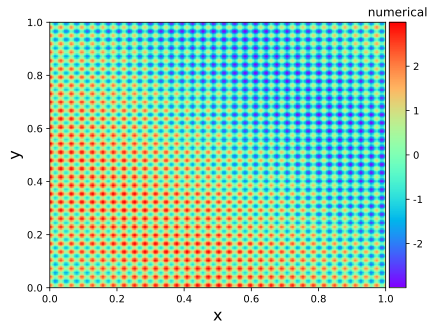

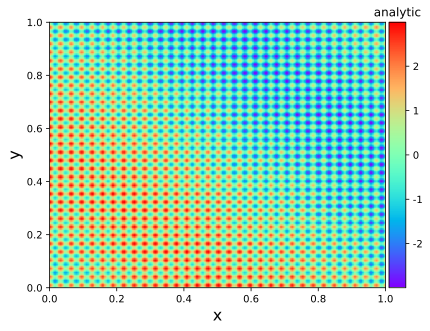

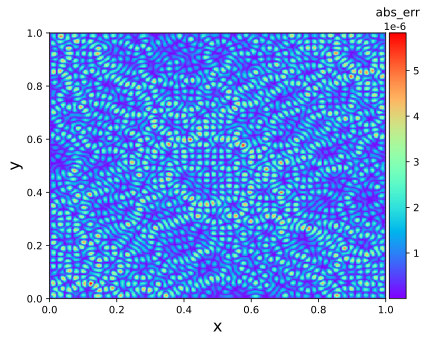

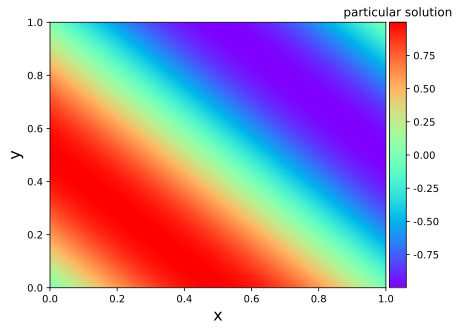

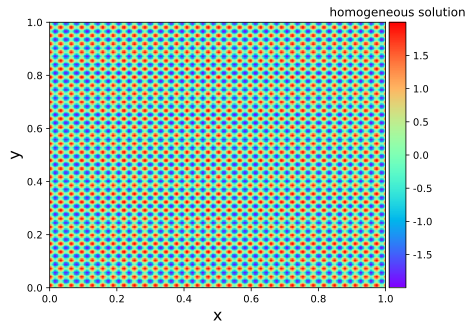

In [139]:
def test_plot(net,axis='x',val=0,save_path=None,n=100):
    x0 = torch.linspace(l_bd, r_bd, n,dtype=torch.float64)
    mx, my = torch.meshgrid(x0, x0)
    mx,my = mx.reshape(-1,1),my.reshape(-1,1)
    if axis=='x':
        X = torch.cat((val*torch.zeros_like(mx),mx,my),1)
    elif axis=='y':
        X = torch.cat((mx,val*torch.zeros_like(mx),my),1)
    else:
        X = torch.cat((mx,my,val*torch.zeros_like(mx)),1)
    net = net.cpu()
    with torch.no_grad():
        u1 = net1(X).reshape(-1,n).T
        u2 = net(X).reshape(-1,n).T
        u = u1+u2
        u_ex = u_exact(X).reshape(-1,n).T
    print(torch.norm(u.flatten()-u_ex.flatten()))
    if save_path is not None:
        plot_sol(u,"numerical,"+axis+"=%.3f"%val,save_path+'/k_%d_u.png'%k)
        plot_sol(u_ex,"analytic,"+axis+"=%.3f"%val,save_path+'/k_%d_u_ex.png'%k)
        plot_sol(abs(u-u_ex),"abs.err,"+axis+"=%.3f"%val,save_path+'/k_%d_u_err.png'%k)
        plot_sol(u1,"particular solution,"+axis+"=%.3f"%val,save_path+'/k_%d_u_ex.png'%k)
        plot_sol(u2,"homogeneous solution,"+axis+"=%.3f"%val,save_path+'/k_%d_u_err.png'%k)
    else:
        plot_sol(u,"numerical,"+axis+"=%.3f"%val)
        plot_sol(u_ex,"analytic,"+axis+"=%.3f"%val)
        plot_sol(abs(u-u_ex),"abs.err,"+axis+"=%.3f"%val)
        plot_sol(u1,"particular solution,"+axis+"=%.3f"%val)
        plot_sol(u2,"homogeneous solution,"+axis+"=%.3f"%val)
    
def plot_sol(u,title="numerical",save_path=None):
    plt.figure()
    ax =  plt.subplot(1,1,1)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    h = plt.imshow(u, interpolation='nearest', cmap='rainbow',
                   extent=[l_bd, r_bd, l_bd, r_bd],
                   origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax) 
    plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
test_plot(net,'imgs/2d_exam7/')

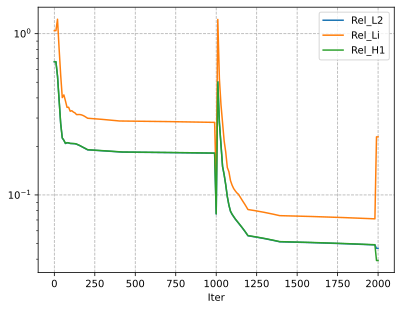

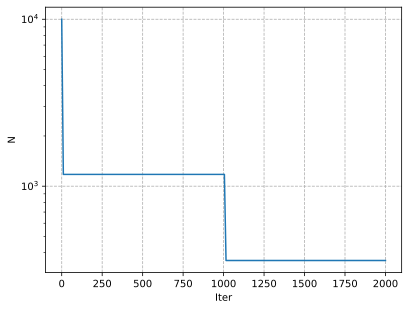

In [ ]:

data = np.load('loss/loss_exam9_%d_%d.npz'%(k,N))
Rel_L2 = data['Rel_L2']
Rel_Li = data['Rel_Li']
Rel_H1 = data['Rel_H1']
N_bf = data['N_bf']
Epoch = torch.linspace(0,data['MaxNiter'][0],Rel_L2.shape[0])
plt.plot(Epoch,Rel_L2)
plt.plot(Epoch,Rel_Li)
plt.plot(Epoch,Rel_H1)
plt.grid(linestyle="--")
plt.xlabel('Iter')
plt.semilogy()
plt.legend(['Rel_L2','Rel_Li','Rel_H1'])
plt.savefig('imgs/2d_exam9/k_%d_rel_err.png'%k)
plt.show()
Epoch = torch.linspace(0,data['MaxNiter'][0],N_bf.shape[0])
plt.plot(Epoch,N_bf)
plt.semilogy()
plt.xlabel('Iter')
plt.ylabel('N')
plt.grid(linestyle="--")
plt.savefig('imgs/2d_exam9/k_%d_N.png'%k)
plt.show()